In [1]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from matplotlib import cm
from pandas.api.types import CategoricalDtype
import matplotlib.patches as mpatches

sb.set_style("whitegrid")

In [3]:
#Helper functions

def calculate_age(born):
    '''
    Helper function for calculation of full age
    Parameters:
    born (pandas Series object with dtype datetime): birth date
    Returns:
    full age (pandas Series object with dtype float)
    
    '''
    born = pd.to_datetime(born.split('/')[0] + '/' + born.split('/')[1] + '/19' + born.split('/')[-1])
    today = pd.to_datetime('09/27/2019')
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_age_term(df):
    '''
    Helper function for calculation of age at the time of termination
    Parameters:
    df (pandas dataframe): dataframe with columns containing dates of birth and dates of termination
    Returns:
    full age when terminated (pandas Series object with dtype float)
    
    '''
    born = df['DOB']
    end = df['DateofTermination']
    born = pd.to_datetime(born.split('/')[0] + '/' + born.split('/')[1] + '/19' + born.split('/')[-1])
    return end.year - born.year - ((end.month, end.day) < (born.month, born.day))

def calculate_age_hired(df):
    '''
    Helper function for calculation of age at the time of hire
    Parameters:
    df (pandas dataframe): dataframe with columns containing dates of birth and dates of hire
    Returns:
    full age when hired (pandas Series object with dtype float)
    
    '''
    born = df['DOB']
    hired = df['DateofHire']
    born = pd.to_datetime(born.split('/')[0] + '/' + born.split('/')[1] + '/19' + born.split('/')[-1])
    hired = pd.to_datetime(df['DateofHire'])
    return hired.year - born.year - ((hired.month, hired.day) < (born.month, born.day))

def calculate_years(series):
    '''
    Helper function for calculation years working for active employees
    Parameters:
    series (pandas Series object with dtype datetime): date of hire
    Returns:
    years working (pandas Series object with dtype float)
    
    '''
    series = pd.to_datetime(series)
    today = pd.to_datetime('09/27/2019')
    return today.year - series.year + round((today.month - series.month) / 12, 1)

def calculate_years_term(df):
    '''
    Helper function for calculation years working for terminated employees
    Parameters:
    df (pandas dataframe): dataframe with columns containing dates of hire and dates of termination
    Returns:
    years working (pandas Series object with dtype float)
    
    '''
    begin = pd.to_datetime(df['DateofHire'])
    end = df['DateofTermination']
    return end.year - begin.year + round((end.month - begin.month) / 12, 1)

def calculate_turnover(df, period = 'M', grouping = None):
    '''
    Helper function for calculation turnover rates
    Parameters:
    - df (pandas dataframe): dataframe with columns containing employee IDs, 
      dates of hire, dates of termination, grouping columns
    - period ('M','Y' or any other period): intervals for turnover calculations
    - grouping (list of column names): columns by which we need the turnover 
      groups (e.g. ['Department', 'Manager'])
    Returns:
    result (pandas Dataframe with appropriate groupings and termination rates)
    
    '''    
    if grouping:
        
        level = []
        for i in range(len(grouping)):
            level.append(i)
        terminated = df.loc[df.DateofTermination.isna() == False].\
        groupby(grouping).resample(rule = period, on = 'DateofTermination').count()
        hired = df.groupby(grouping).resample(rule = period, on = 'DateofHire').count()
        result = pd.concat([hired['EmpID'], terminated['EmpID']], axis = 1).fillna(0)
        result.columns = ['Hired','Terminated']
        result['Period_end'] = result.groupby(level=level).cumsum()['Hired'] - \
        result.groupby(level=level).cumsum()['Terminated']
        result['Period_start'] = result.groupby(level=level)['Period_end'].shift(1).fillna(0)

    else:
        
        terminated = df.resample(rule = period, on = 'DateofTermination').count()
        hired = df.resample(rule = period, on = 'DateofHire').count()
        result = pd.concat([hired['EmpID'], terminated['EmpID']], axis = 1).fillna(0)
        result.columns = ['Hired','Terminated']
        result['Period_end'] = result['Hired'].cumsum() - result['Terminated'].cumsum()
        result['Period_start'] = result['Period_end'].shift(1).fillna(0)
    
    result['Turnover'] = result.apply(lambda x: 100 if (x.Period_end == 0.0) & (x.Period_start == 0.0) 
                                     else round(x.Terminated / ((x.Period_end + x.Period_start) / 2.0) * 100, 2), axis = 1)
    
    return result

def one_hot_encoding(df, cols):
    for col in cols:
        df = pd.concat([df,pd.get_dummies(df[col], prefix=col,
                                          drop_first=True)],axis=1)
    return df

In [4]:
def high_manager_turnover_visualization(periods):
    '''
    Helper function for visualizing turnover dataframe
    Parameters:
    - periods (int): number of periods (threshold to use in order to identify managers whose 
      turnover rates are above department levels for this number of periods or more)
    Returns:
    - fig: visualization
    - managers: list of managers
    
    '''   
    num_periods = periods
    temp = yearly_turnover_manager['Turnover']
    temp1 = yearly_turnover_department['Turnover'].reset_index()

    temp = temp.reset_index().merge(temp1, 
                                    left_on = ['level_1','level_2'],
                                    right_on = ['level_0', 'level_1'])

    higher_than_dep = temp[temp.Turnover_x > temp.Turnover_y]
    filt = higher_than_dep.groupby(['level_0_x','level_1_x']).size() >= num_periods

    temp2 = yearly_turnover_manager.reset_index()
    temp = yearly_turnover_manager.reset_index().merge(filt.reset_index(), 
                                    left_on = ['level_0','level_1'],
                                    right_on = ['level_0_x', 'level_1_x'])
    temp=temp[temp[0] == True]
    temp.loc[:,'Year'] = temp.loc[:,'level_2'].apply(lambda x: x.year)
    temp = temp.set_index('Year')
    temp1.loc[:,'Year'] = temp1.loc[:,'level_1'].apply(lambda x: x.year)
    temp1 = temp1.set_index('Year')


    deps = temp.level_1.unique()

    plots = len(deps)
    cols = 2
    rows = plots // cols
    rows += plots % cols
    position = range(1, plots + 1)

    fig = plt.figure(figsize = (15,5*rows))
    for i in range(plots):

        ax = fig.add_subplot(rows, cols, position[i])
        df1 = temp[temp.level_1 == deps[i]]
        df2 = temp1[temp1.level_0 == deps[i]]
        sb.lineplot(x = df1.index, 
            y = 'Turnover', hue = 'level_0',
            marker = 'x', data = df1, ax = ax)

        sb.lineplot(x = df2.index, y = 'Turnover',
                    marker = 'o', data = df2, ax = ax, color = 'r')
        ax.set_title(deps[i], pad = 16)
        ax.set_xlabel('')
        ax.lines[-1].set_linestyle("--")
        ax.lines[-1].set_label('Total department turnover')
        handles, labels = ax.get_legend_handles_labels()
        handles, labels = handles[::-1], labels[::-1]
        leg = ax.legend(handles[:-1], labels[:-1], loc='upper center',
                        ncol = 3, bbox_to_anchor=(0.5, -.1))

    fig.tight_layout(pad=1.0)
    fig.suptitle('Yearly turnover by manager (turnover above department level\n\
    for {} and more periods)'.format(num_periods), fontsize=16, y = 1.1)
    temp = temp.drop_duplicates(['level_0','level_1'])[['level_0','level_1']]
    temp.columns = ['ManagerName','Department']

    return fig, temp

In [5]:
# Data cleaning

df = pd.read_csv('human-resources-data-set.zip')
df = df[:310]
df.loc[3, 'EmpStatusID'] = 4.0
df.loc[271,'ManagerID'] = 22.0
df.loc[300,'ManagerID'] = 1.0
df.loc[df['ManagerName'] == 'Webster Butler', 'ManagerID'] = 39.0

# Feature generation

df['LogPayRate'] = np.log(df['PayRate'])
df['Department'] = df['Department'].str.strip()
df['TermReason'] = df['TermReason'].str.capitalize()
df['DateofTermination'] = pd.to_datetime(df['DateofTermination'])
df['DateofHire'] = pd.to_datetime(df['DateofHire'])
df['RecruitmentSource'] = pd.Categorical(df['RecruitmentSource'])
df['RecruitmentSource_int'] = df['RecruitmentSource'].cat.codes
df['RaceDesc'] = pd.Categorical(df['RaceDesc'])
df['RaceDesc_int'] = df['RaceDesc'].cat.codes
df['TermReason'] = pd.Categorical(df['TermReason'])
df['TermReason_int'] = df['TermReason'].cat.codes
df['CitizenDesc'] = pd.Categorical(df['CitizenDesc'])
df['CitizenDesc_int'] = df['CitizenDesc'].cat.codes
df['State'] = pd.Categorical(df['State'])
df['State_int'] = df['State'].cat.codes
df.loc[df['LastPerformanceReview_Date'].isna() == True, 'Performance_review'] = 0
df.loc[df['LastPerformanceReview_Date'].isna() == False, 'Performance_review'] = 1
df['FullAge'] = df['DOB'].apply(calculate_age)
df['YearHired'] = df['DateofHire'].apply(lambda x: x.year)
df.loc[df['DateofTermination'].isna() == True, 'YearsWorking'] = \
df.loc[df['DateofTermination'].isna() == True]['DateofHire'].apply(calculate_years)
df.loc[df['DateofTermination'].isna() == False, 'YearsWorking'] = \
df.loc[df['DateofTermination'].isna() == False].apply(calculate_years_term, axis = 1)
df.loc[df['DateofTermination'].isna() == False, 'AgeWhenTerminated'] = \
df.loc[df['DateofTermination'].isna() == False].apply(calculate_age_term, axis = 1)
df.loc[df['DateofTermination'].isna() == True, 'AgeWhenTerminated'] = \
df.loc[df['DateofTermination'].isna() == True, 'FullAge']
df['AgeWhenHired'] = df.apply(calculate_age_hired, axis = 1)
df.loc[(df['MarriedID'] == 1) & (df['GenderID'] == 1), 'Married_male'] = 1
df.loc[df['Married_male'].isna(), 'Married_male'] = 0
df.loc[(df['MarriedID'] == 1) & (df['GenderID'] == 0), 'Married_female'] = 1
df.loc[df['Married_female'].isna(), 'Married_female'] = 0
df['AgeTerm_sq'] = (df['AgeWhenTerminated'] ** 2) / 10
df['LogAgeTerm'] = np.log(df['AgeWhenTerminated'])
df.loc[df['HispanicLatino'].str.contains('Yes') | df['HispanicLatino'].str.contains('yes'),
       'HispanicLatino_int'] = 1
df.loc[df['HispanicLatino'].str.contains('No') | df['HispanicLatino'].str.contains('no'),
       'HispanicLatino_int'] = 0

involuntary = ['Attendance', 'Performance', 'Gross misconduct']

voluntary_career = ['Career change','Another position']
voluntary_unhappy = ['Hours', 'Unhappy','More money']
voluntary_personal = ['Relocation out of area','Medical issues',
                      'Return to school', 'Military','No-call, no-show',
                      'Maternity leave - did not return','Retiring']
    
df.loc[df['TermReason'].isin(involuntary), 'TermReasonGroup'] = 'Involuntary'
df.loc[df['TermReason'].isin(voluntary_career), 'TermReasonGroup'] = 'Voluntary_career'
df.loc[df['TermReason'].isin(voluntary_unhappy), 'TermReasonGroup'] = 'Voluntary_unhappy'
df.loc[df['TermReason'].isin(voluntary_personal), 'TermReasonGroup'] = 'Voluntary_personal'
cat_type = CategoricalDtype(categories=['Involuntary', 'Voluntary_personal',
                                        'Voluntary_career', 'Voluntary_unhappy'],ordered=True)
df['TermReasonGroup'] = df['TermReasonGroup'].astype(cat_type)
df = one_hot_encoding(df, ['MaritalStatusID', 'CitizenDesc_int', 'DeptID', 'PositionID', 'ManagerID',
                            'RecruitmentSource_int', 'RaceDesc_int', 'HispanicLatino_int', 'PerfScoreID'])

## Introduction

In this blog-post we will be looking at one of the most important HR metrics in any company - employee turnover. According to The Society for Human Resource Management (SHRM) research, direct replacement costs can reach as high as 50%-60% of an employee’s annual salary.

We used dataset prepared by New England College of Business of graduate MSHRM courses called HR Metrics and Analytics. It simulates an IT company and covers period from 2006 to 2017. Information includes data on all employees, their job statuses, pay rates, marital statuses and other data usually avaialable for HR analytics. Using available information I will try to find answers to the following questions:

1. What are the overall and department-wise turnover rates in the company? What managers have the highest turnover rates? What are the main reasons for resignation?
2. Could simple regression model be used to identify correlation between different factors and probability of resignation?

## Turnover rates and main reasons for resignation

In [160]:
yearly_turnover = calculate_turnover(df, 'Y')
yearly_turnover = yearly_turnover.loc['2010-12-31':]
yearly_turnover_department = calculate_turnover(df, 'Y', ['Department'])
yearly_turnover_department = yearly_turnover_department.loc(axis = 0)[:, '2010-12-31':]
yearly_turnover_manager = calculate_turnover(df, 'Y', ['ManagerName','Department'])
yearly_turnover_manager = yearly_turnover_manager.loc(axis = 0)[:,:, '2010-12-31':]

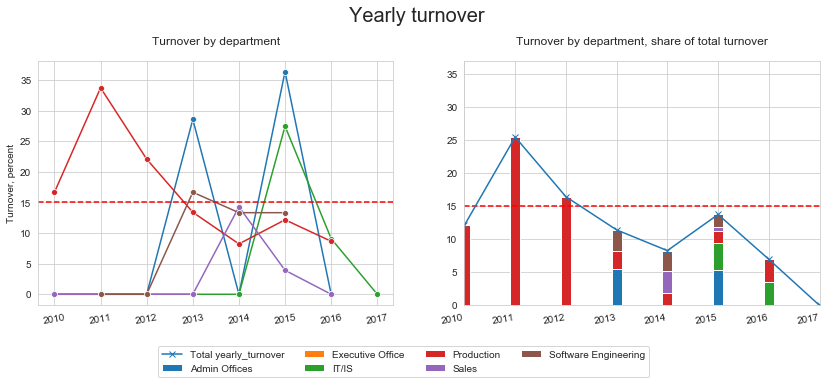

In [193]:
fig = plt.figure(figsize = (14, 5))
fig.suptitle('Yearly turnover', y = 1.03, fontsize = 20)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.ylim(0,37)

temp = yearly_turnover_department.reset_index()
sb.lineplot(x = temp['level_1'].map(lambda x: x.year), 
            y = 'Turnover', hue = 'level_0',
            marker = 'o', data = temp, ax = ax1,legend=None)

ax1.axhline(15, color='r', linestyle='--')

ax1.set_xlabel('')
ax1.set_ylabel('Turnover, percent')
ax1.set_title('Turnover by department', pad = 16)

temp = yearly_turnover_department.unstack()['Turnover'].fillna(0).apply(lambda x: x/x.sum(), axis = 0)
temp = temp.fillna(0) * yearly_turnover['Turnover']
temp = temp.T.set_index(temp.T.index.year)
temp.plot(kind='bar',stacked=True, width = 0.2, ax = ax2, legend=False)
ax2.axhline(15, color='r', linestyle='--');
yearly_turnover['Turnover'].plot(marker = 'x', ax = ax2, use_index=False);
ax2.set_title('Turnover by department, share of total turnover', pad = 16)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=10)
    
handles, labels = ax2.get_legend_handles_labels()
labels[0] = 'Total yearly_turnover'
fig.legend(handles, labels, loc='upper center',
           ncol = 4, bbox_to_anchor=(0.4, .11));


According to Linkedin, technology sector's average turnover rate in 2017 was approximately 13.2%. Looking at a yearly turnover rates department-wise, we see that Production, Admin Offices and IT/IS departments had turnovers above 15% at some points. However, if we look at these departments' contribution into yearly turnover rates, it seems that only Production looks troublesome. Overall yearly turnover does not exceed our threshold of 15% during last four years.

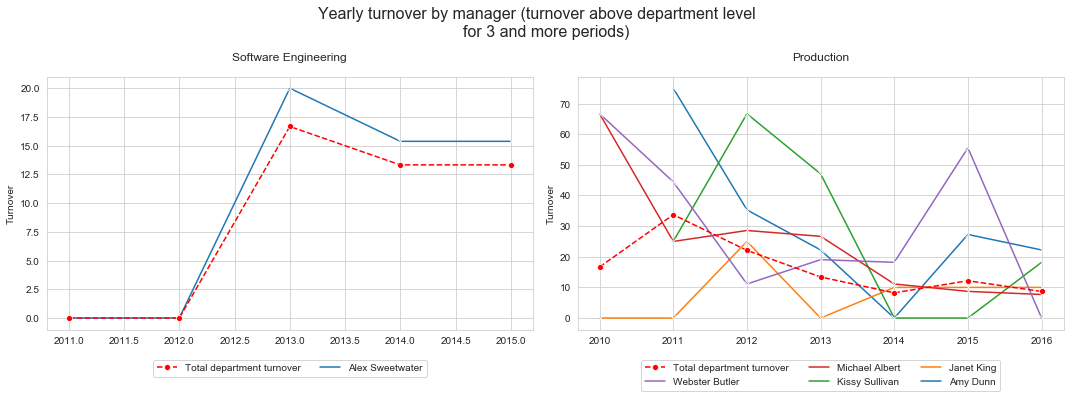

In [174]:
fig, managers = high_manager_turnover_visualization(periods = 3)

Next, let's look into different departments' turnover rates broken down by managers. At the figure above we can see graphs of the yearly turnover rates for those managers whose turnover values were above the respecitve department levels for three and more years. We see that only six of Software Engineering and Production departments' managers fall under this category. We could dig deeper and identify main termination reasons given by their ex-subordinates.

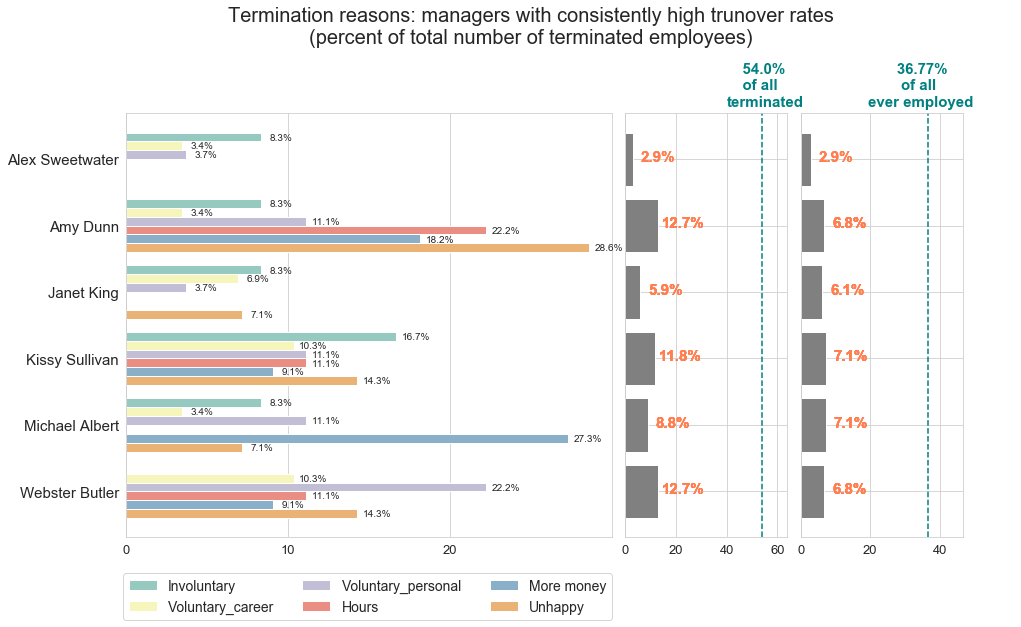

In [194]:
temp = df.copy()
temp['TermReason'] = np.where(temp.TermReasonGroup == 'Voluntary_unhappy', 
                              temp['TermReason'], temp['TermReasonGroup'])
managed_total = temp.groupby('ManagerName').count()[['EmpID']].div(len(temp))* 100
managed_total.columns = ['Managed_total']
temp = temp[temp.Termd == 1].groupby(['ManagerName','Department','TermReason']).count().fillna(0)
temp = temp[temp.EmpID != 0]
total_term = temp['EmpID'].sum()
temp['Percent_dept'] = temp['EmpID'].div(temp.groupby(level = 1).transform('sum')['EmpID']).fillna(0) * 100
temp['Percent_reason_total'] = temp['EmpID'].div(temp.groupby(level = 2, observed = True).transform('sum')['EmpID']).fillna(0) * 100
temp['Percent_reason_dept'] = temp['EmpID'].div(temp.groupby(level = [1,2], observed = True).
                                                transform('sum')['EmpID']).fillna(0) * 100
temp['Percent_total'] = temp['EmpID'] / total_term * 100
temp['Percent_manager_total'] = temp.groupby(level = 0).transform('sum')['EmpID'].div(total_term) * 100
managed_total, _ = managed_total.align(temp, level=0, axis=0)
temp['Managed_total'] = managed_total['Managed_total']

temp = temp[['EmpID', 'Percent_dept', 'Percent_reason_dept', 'Percent_total', 
             'Percent_reason_total','Percent_manager_total','Managed_total']]
tuples = [tuple(x) for x in managers.values]
temp = temp.reset_index(level=2).loc[tuples]
temp = temp.reset_index()
share_of_total_term = round(temp['EmpID'].sum() / total_term * 100)
share_of_total = round(temp[['ManagerName','Managed_total']].
                       drop_duplicates()['Managed_total'].sum(), 2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [3, 1, 1]}, 
                               figsize = (15, len(temp.ManagerName.unique())*1.3),sharey=True)


sb.barplot(y = 'ManagerName', x = 'Percent_reason_total', hue = 'TermReason',
          data = temp, ax = ax1, palette='Set3')

ax1.legend(loc='center left', ncol = 3,
          bbox_to_anchor=(-.02, -0.14),prop={'size':14})

start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 10))
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.tick_params(axis='x', which='major', labelsize=13)

plt.suptitle('Termination reasons: managers with consistently high trunover rates\n\
(percent of total number of terminated employees)', y = 1.07, fontsize = 20)

ax2.barh(temp.ManagerName, temp.Percent_manager_total, color = 'grey')
ax2.invert_yaxis()
ax2.set_xlim(0,share_of_total_term + 10)
    
ax2.axvline(share_of_total_term, color='teal', linestyle='--');
ax2.tick_params(axis='both', which='major', labelsize=13)

ax3.barh(temp.ManagerName, temp.Managed_total, color = 'grey')
ax3.invert_yaxis()
ax3.set_xlim(0,share_of_total + 10)
ax3.axvline(share_of_total, color='teal', linestyle='--');
ax3.tick_params(axis='both', which='major', labelsize=13)

for p in ax1.patches:
    h = p.get_y() + p.get_height() / 2
    x = p.get_width()
    if x != 0:
        ax1.annotate(str(round(p.get_width(), 1))+"%", xy=(x,h), xytext=(20,-5), 
                   textcoords="offset points", ha="center", va="bottom")
    
for p in ax2.patches:
    h = p.get_y() + p.get_height() / 2
    x = p.get_width()
    if x != 0:
        ax2.annotate(str(round(p.get_width(), 1))+"%", xy=(x,h), xytext=(25,-5),
                     textcoords="offset points", ha="center", va="bottom", color='coral', 
                     fontweight='bold', fontsize = 15)

for p in ax3.patches:
    h = p.get_y() + p.get_height() / 2
    x = p.get_width()
    if x != 0:
        ax3.annotate(str(round(p.get_width(), 1))+"%", xy=(x,h), xytext=(25,-5),
                     textcoords="offset points", ha="center", va="bottom", color='coral', 
                     fontweight='bold', fontsize = 15)
        
plt.annotate('    {}%\n    of all\nterminated'.format(share_of_total_term),fontweight='bold', fontsize=15,
            xy=(0.711, 0.83), xycoords='figure fraction',color='teal')
        
plt.annotate('       {}%\n        of all\never employed'.format(share_of_total),fontweight='bold', fontsize=15,
            xy=(0.85, 0.83), xycoords='figure fraction',color='teal')
plt.subplots_adjust(wspace=0.05);

The left part of the plot above depicts breakdown of number of employees who had worked under subject managers' command and terminated for different reasons as shares of total number of staff members terminated for corresponding reasons. Some of the particularly notable numbers include: 

- Around 71% of all people who left the company and listed "Unhappy" as their reasons for termination.
- 44% of all overworked employees.
- 50% of all involuntarily terminated employees (dismissed due to either non-adherence to company policies or performance issues).

As we can see on the two righmost plots, these six managers (out of 21 managers in total) had 54% of all ever terminated people as their subordinates and jointly managed around 37% of all people ever employed in the company. For some of the managers the share of terminations is somewhat consistent with the share of totally managed people, whereas for others these values vary significantly.

Next, let's look into termination reasons at the department level.

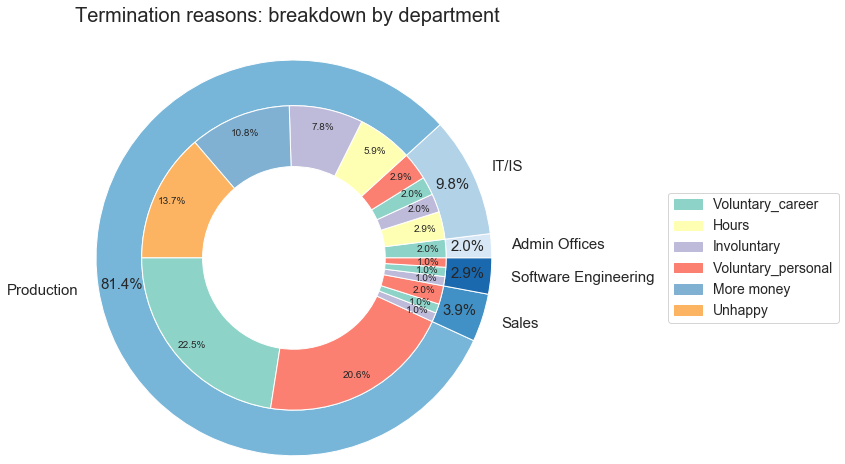

In [180]:
temp = df.copy()
temp['TermReason'] = np.where(temp.TermReasonGroup == 'Voluntary_unhappy', 
                              temp['TermReason'], temp['TermReasonGroup'])
temp = temp[temp.Termd == 1].groupby(['Department','TermReason']).count().fillna(0)
temp = temp[temp.EmpID != 0]
total_term = temp['EmpID'].sum()
temp['Percent_dept'] = temp['EmpID'].div(temp.groupby(level = 0).transform('sum')['EmpID']).fillna(0) * 100
temp['Percent_total'] = temp.groupby(level = 0).transform('sum')['EmpID'].div(total_term) * 100

temp = temp[['EmpID', 'Percent_dept', 'Percent_total']]

temp = temp.reset_index()

fig, ax = plt.subplots(figsize = (7,7))
ax.axis('equal')

fig.suptitle('Termination reasons: breakdown by department', y = 1., fontsize = 20)

outer_pie = temp[['Department','Percent_total']].drop_duplicates()
inner_pie = temp[['TermReason','Percent_dept','Percent_total']]
inner_pie.loc[:,'Percent_dept'] = inner_pie.apply(lambda x: x['Percent_dept'] /\
                                            100 * x['Percent_total'], axis=1)

# Drawing outer pie

cmap = plt.get_cmap('Blues')
outer_colors = cmap(np.arange(len(outer_pie['Department'].unique()))*40+40)

mypie, _, _ = ax.pie(outer_pie['Percent_total'], radius = 1.3,
                  labels = outer_pie['Department'],
                  colors = outer_colors, autopct = '%1.1f%%',
                  pctdistance = .88,
                  textprops={'fontsize': 15})

plt.setp(mypie, width=0.3)

# Drawing inner pie

cmap = plt.get_cmap('Set3')
labels = inner_pie['TermReason']
inner_colors = cmap(np.arange(len(labels.unique())))
color_dict = {j: k for j, k in zip(labels.unique(), inner_colors)} 
inner_colors = [color_dict[i] for i in labels]

mypie2, _, _ = ax.pie(inner_pie['Percent_dept'], radius=1.3-0.3,
                      autopct = '%1.1f%%', pctdistance = .88,
                      colors = inner_colors)

plt.setp(mypie2, width=0.4, edgecolor='white')

patchList = []
for key in color_dict:
    data = mpatches.Patch(color = color_dict[key], label = key)
    patchList.append(data)
    
plt.legend(handles = patchList, loc='center left', ncol = 1,
          bbox_to_anchor=(1.44, 0.5),prop={'size':14});


The figure above demonstrates termination reasons data broken down by department. It is interesting to note, that higher remuneration has been the incentive for termination only for employees of Production department. Also, only Production staff indicated "Unhappy" as their main reason for leaving the company.

## Logistic regression

In order to identify factors that correlate with termination, we used simple logistic regression.

Since our data has many explanatory variables, we applied "general-to-specific" approach, namely, we included as many variables as possible in the first iteration of the modeling and excluded variables with the lowest z-score at every subsequent iteration. Our final model includes only those variables whose Z-scores exceed threshold of 1.96 which is a critical value for statistical significance when using 95% confidence level. The p-value of the likelihood ratio chi-square for our model is 3.4107e-55 which tells us that the model fits the data significantly better than a hypothetical "empty" model that includes only intercept.

In [176]:
import statsmodels.api as sm

x_cols = ['FromDiversityJobFairID', 'AgeWhenTerminated',
          'LogAgeTerm', 'SpecialProjectsCount', 'YearsWorking']

x = df.loc[:,x_cols].copy()
x.insert(0, 'Const', np.ones(len(df)))
model = sm.Logit(df['Termd'], x)
result = model.fit()
coef = result.summary2().tables[1]
coef['Odds'] = np.round(np.exp(coef['Coef.']), 3)
print('\nLLR p-value: {}\n'.format(result.summary2().tables[0].loc[5,3]))
print('Coefficient estimators:\n{}'.format(coef[['Coef.','z','Odds']]))

Optimization terminated successfully.
         Current function value: 0.208439
         Iterations 9

LLR p-value: 3.4107e-55

Coefficient estimators:
                            Coef.         z          Odds
Const                   51.362373  2.419003  2.024860e+22
FromDiversityJobFairID   1.949337  2.586719  7.024000e+00
AgeWhenTerminated        0.393063  2.120686  1.482000e+00
LogAgeTerm             -16.587764 -2.132534  0.000000e+00
SpecialProjectsCount    -0.521339 -4.354559  5.940000e-01
YearsWorking            -1.627609 -7.564817  1.960000e-01


The easiest way to interpret obtained coefficient estimators is to express them in terms of odd-ratios. By exponentiating coefficient estimators we yield following results:

1. The odds of termination are 7 times higher in case an employee was hired through a diversity job fair. This result is quite interesting. The data might indicate that company's inclusion initiatives do not work as effectively in the long run.
2. For a one unit increase in the number of special project that an employee performed, the odds of them leaving the company decrease by 68% (1 / 0.594).
3. With each additional year that an employee stays with the company, the odds of them leaving decreases by more than 5 times (1 / 0.196).
4. In order to interpret coefficient estimators of the combination of the termination age variable and its logarithmic transformation, we will consider the odds-ratio formula:

    $\frac{{Pr}\left[Termd_i = 1\right]}{{Pr}\left[Termd_i = 0\right]}=exp(51.36)\times7.024^{JobFair_i}\times0.594^{SpecProj_i}\times0.196^{YersWork_i}\times{exp}(-16.588\ln(AgeTerm_i)+0.393AgeTerm_i)$
    
    To find the age for which we have the highest value of the termination odds ratio, we need to take a first order derivative of the odds-ratio with respect to the AgeWhenTerminated varaible and equate it to zero:
    
    $\frac{\partial{Pr}\left[Termd_i = 1\right]}{\partial\beta_{AgeTerm}} =\left[exp(51.36)\times7.024^{JobFair_i}\times0.594^{SpecProj_i}\times0.196^{YersWork_i}\times{exp}(-16.588ln(AgeTerm_i)+0.393AgeTerm_i)\right]\times(-\frac{16.588}{AgeTerm_i}+0.393)=0$
    
    Solving this equation we find the answer to be 42.2 years.

## Conclusion

In this post we made an attempt at analyzing turnover of an IT company and identify some factors that might affect termination rates. The subject of turnover, of course, could be analyzed from many other aspects that were not covered here. Some of the more interesting observations identified in the course of the analisys are the following:

1. Some of the managers have consistently high turnover rates while a great deal of their subordinates had left the company for reasons other than changes in their personal circumstances or career transitions.
2. Remuneration rates in the Production department might not be consistent with market levels.
3. Employees brought in through company's diversity efforts seem to leave the company several times more often than those who were hired through other channels.